# Cascaded Swirl Reservoir + Complex Readout

## Imports

In [1]:
%matplotlib inline

# main imports
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

# photontorch
import photontorch as pt
from photontorch_rc import PhotonicSwirlNetwork
from torch.nn import Parameter
from photontorch.torch_ext.nn import Buffer

# other
from tqdm.notebook import trange # progress bars
from scipy.signal import butter, lfilter # bit smoothing

# mpl style context manager
custom_style = lambda : plt.style.context(os.path.abspath('custom.mplstyle'))

## Parameters & Settings

In [2]:
# simulation parameters
dt = 1e-12 # simulation timestep
bitrate = 50e9 # bps
samplerate = 1/dt # new sampling rate
power = 1e-3 #[W]
S = int(samplerate/bitrate+0.5) # timesteps per bit (sampling points per bit)

# training parameters
num_train_bits = 1000
num_test_bits = 10000
learning_rate=0.1
train_bits_seed = 23
test_bits_seed = 42
batch_size = 10 # number of parallel simulations to run during training
latencies = np.array([2.1]) # how many bits delay

# source and detector locations:
height = 3
width = 6
sources_at = [1, 8, 15, 22, 29, 35]
detectors_at = slice(None) # all nodes are output nodes
trainable_nodes = []#[6, 11, 17, 22, 28, 33]

# default computation device (cuda or cpu)
device = 'cuda'

# set general seed
torch.manual_seed(7)
np.random.seed(0)

## Visualization

In [3]:
def tplot(dt, field, **kwargs):
    ''' useful visualization function '''
    if torch.is_tensor(field):
        field = field.data.detach().cpu().numpy()
        if field.shape[0]==2:
            field = field[0] + 1j*field[1]
    t = 1e12*np.arange(field.shape[0])*dt + kwargs.pop('start', 0)
    plt.xlabel('time [ps]')
    return plt.plot(t, np.real(field), **kwargs)

## Bit Streams

In [4]:
def generate_bits(num_bits, seed=None):
    ''' generate a random bit stream '''
    if seed is not None:
        r = np.random.RandomState(seed=seed)
    else:
        r = np.random
    bits = r.rand(num_bits) > 0.5
    bits[0] = 1 # no use having 0-bits in front of the stream
    return bits

In [5]:
def bitstream(bits, bitrate=bitrate, samplerate=samplerate):
    bitstream = np.vstack([bits]*int(samplerate/bitrate+0.5)).T.ravel()
    border_freq = 150e9 # way too high, but we use this just to smoothen the bits
    filter_order = 1
    cutoff = border_freq / (0.5*samplerate)
    b, a = butter(filter_order, cutoff, btype='lowpass', analog=False)
    bitstream = lfilter(b, a, bitstream, axis=0)
    bitstream = torch.tensor(bitstream, dtype=torch.get_default_dtype(), device=device)
    return bitstream

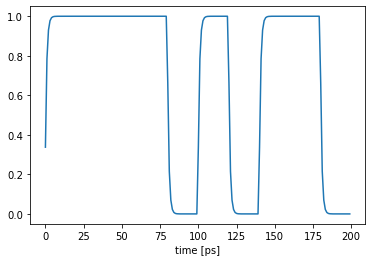

In [6]:
bits = generate_bits(10)
stream = bitstream(bits, bitrate, samplerate)
tplot(dt, stream)
plt.show()

## Bit operations

In [7]:
def xor(bits):
    return (np.hstack([bits,[0]])^np.hstack([[0],bits]))[:-1]
def xor2(bits):
    return (np.hstack([bits,[0,0]])^np.hstack([[0,0],bits]))[:-2]
def xor3(bits):
    output = np.hstack([bits,[0,0]])
    output ^= np.hstack([[0], bits, [0]])
    output ^= np.hstack([[0,0], bits])
    return output[:-2]

# xor = xor2

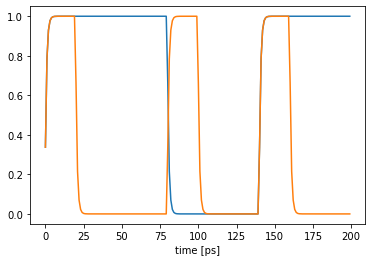

In [8]:
bits = generate_bits(10)
# target_bits = xor(bits)
target_bits = xor(bits)
stream = bitstream(bits)
target_stream = bitstream(target_bits)
tplot(dt,stream)
tplot(dt,target_stream)
plt.show()

## Train: Weight First, Detect Last

### Metrics

In [9]:
def bit_error_rate(y_true, y_pred, bit_threshold=0.5):
    return torch.mean(((y_true > bit_threshold) != (y_pred > bit_threshold)).float())

def mean_squared_error(y_true, y_pred):
    return torch.mean((y_true-y_pred)**2)

### Generate streams

In [10]:
# Training set
train_bits = generate_bits(num_train_bits, seed=train_bits_seed)
train_stream = bitstream(train_bits)
train_target = bitstream(xor(train_bits))

# Test set
test_bits = generate_bits(num_test_bits, seed=test_bits_seed)
test_stream = bitstream(test_bits)
test_target = bitstream(xor(test_bits))

## Multiple Latencies

It is way more efficient to simultaneously train for multiple latencies with the data splitted into different batches...

In [11]:
# first we create different shifted versions of the bitstream for each latency
train_streams = []
train_targets = []
for i, latency in enumerate(latencies):
    L = int(latency*samplerate/bitrate + 0.5)
    M = int(max(latencies)*samplerate/bitrate + 0.5) + 1
    train_streams.append(train_stream[L:-M+L])
    train_targets.append(train_target[:-M])
train_streams = torch.stack(train_streams, 1)
train_targets = torch.stack(train_targets, 1)

# next, we split this bitstream into batches to speed up the training
train_stream_batches = torch.split(train_streams, train_streams.shape[0]//batch_size, 0)[:-1]
train_target_batches = torch.split(train_targets, train_targets.shape[0]//batch_size, 0)[:-1]
train_streams = torch.stack(train_stream_batches, 1) # shape = (timesteps_per_batch, #batches, #latencies)
train_targets = torch.stack(train_target_batches, 1) # shape = (timesteps_per_batch, #batches, #latencies)

# print out resulting shape of the tensor used for training:
print('resulting shape: (timesteps_per_batch=%i, batch_size=%i, #latencies=%i)'%train_streams.shape)

resulting shape: (timesteps_per_batch=1995, batch_size=10, #latencies=1)


## Reservoir

Define the reservoir module:

In [12]:
class Reservoir(torch.nn.Module):
    def __init__(self, height, width, sources_at, detectors_at):
        torch.nn.Module.__init__(self)
        sources_at = np.arange(2*width*height)[sources_at]
        detectors_at = np.arange(2*width*height)[detectors_at]
            
        # Input weights (random phase + division of power; not trainable)
        input_dim = 1
        output_dim = len(sources_at)
        phase_in = 2*np.pi*torch.rand(input_dim, output_dim, device=device)
        self.register_buffer('rWin', (1.0/output_dim)*torch.cos(phase_in))
        self.register_buffer('iWin', (1.0/output_dim)*torch.sin(phase_in))
        
        self.sources_at1 = list(sources_at[sources_at<width*height])
        self.num_sources1 = len(self.sources_at1)
        self.sources_at2 = list(sources_at[sources_at>=width*height] - width*height)
        
        self.detectors_at1 = list(detectors_at[detectors_at<width*height])
        self.detectors_at2 = list(detectors_at[detectors_at>=width*height]-width*height)
        
        # first reservoir
        self.reservoir1 = PhotonicSwirlNetwork(
            height=height,
            width=width,
            node_delay=int(samplerate/bitrate+0.5)*dt,
            signal_freq=samplerate,
            loss_dB=1.0,
            sources_at = self.sources_at1,
            detectors_at = self.detectors_at1,
        ).to(device)
        
        
        # intermediate weights
        self.rV = torch.nn.Parameter(torch.rand((width*height,width*height), dtype=torch.float32, device=device))
        self.iV = torch.nn.Parameter(torch.rand((width*height,width*height), dtype=torch.float32, device=device))
        
        # second reservoir
        self.reservoir2 = PhotonicSwirlNetwork(
            height=height,
            width=width,
            node_delay=int(samplerate/bitrate+0.5)*dt,
            signal_freq=samplerate,
            loss_dB=1.0,
            sources_at = list(range(width*height)),
            detectors_at = self.detectors_at2,
        ).to(device)
        
        # trainable nodes
        for i in np.arange(2*height*width)[trainable_nodes]:
            res_idx = i//(height*width) + 1
            idx = i - (res_idx==2)*width*height
            wg = getattr(self, 'reservoir%i'%res_idx).components['waveguide%i'%idx]
            wg.phase = torch.nn.Parameter(wg._buffers.pop('phase').data)
        
        # output weights; random, complex and trainable
        self.rW = Parameter(torch.rand((len(detectors_at)), dtype=torch.float32, device=device))
        self.iW = Parameter(torch.rand((len(detectors_at)), dtype=torch.float32, device=device))
        
        # detector
        self.detector = pt.Photodetector(bitrate=bitrate, dt=dt).to(device)
        
        # optimizer
        self.optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
    
    def forward(self, x):
        self.reservoir2.initialize()
        
        with torch.no_grad():
            # get environment
            env = pt.current_environment()
            self.reservoir1.initialize()

            # check if input is complex
            if x.shape[0] != 2:
                x = torch.stack([x, torch.zeros_like(x)], 0)

            # x should have shape (2, timesteps_per_batch, batch_size, #latencies)
            _, a, b, c = x.shape

            # batch together batches and latencies
            batch_size = b*c
            x = x.view(2, a, batch_size)

            # add CW bias [disabled]
            #x = torch.stack([x, torch.zeros_like(x)], -1)
            # add single input dim instead:
            x = x[...,None]

            # apply Win2res:
            x = torch.stack([
                x[0]@self.rWin - x[1]@self.iWin,
                x[0]@self.iWin + x[1]@self.rWin,
            ], 0)
            
            x1 = x[..., :self.num_sources1]
            x2 = x[..., self.num_sources1:]

            # bring tensor in standard shape (add dim for wls etc...)
            x1 = self.reservoir1.handle_source(x1)

            # create tensor to store detected:
            detected1 = torch.zeros((2, a, 1, self.reservoir1.num_detectors, batch_size), device=device)
            detected2 = torch.zeros((2, a, 1, self.reservoir2.num_detectors, batch_size), device=device)

            # create buffer for the simulation
            buffer1 = self.reservoir1.simulation_buffer(batch_size)
            buffer2 = self.reservoir2.simulation_buffer(batch_size)

            # solve
            for i, t in enumerate(env.time):
                det1, buffer1 = self.reservoir1.step(t, x1[:,i], buffer1)
                detected1[:,i] = det1
        
        # start tracking gradients from here on:

        r = torch.matmul(torch.transpose(detected1[0], -1, -2), self.rV) 
        r -= torch.matmul(torch.transpose(detected1[1], -1, -2), self.iV)
        i = torch.matmul(torch.transpose(detected1[0], -1, -2), self.iV) 
        i += torch.matmul(torch.transpose(detected1[1], -1, -2), self.rV)

        #x = torch.transpose(torch.stack([r, i], 0), -1, -2)
        x = torch.transpose(torch.stack([r, torch.zeros_like(i)], 0), -1, -2)
        #x = torch.transpose(self.detector(r**2 + i*2), -1, -2)


        #x = torch.transpose(torch.sqrt(r**2+i**2), -1, -2)
        x = self.reservoir2.handle_source(x)
        x2 = torch.transpose(x2[:,:,None], -1, -2) # add dimension for wavelength
        x[:,:,:,self.sources_at2,:] += x2

        for i, t in enumerate(env.time):
            det2, buffer2 = self.reservoir2.step(t, x[:,i], buffer2)
            detected2[:,i] = det2

        detected = torch.transpose(torch.cat([detected1, detected2], -2), -1, -2)
        
        r = torch.matmul(detected[0], self.rW) 
        r -= torch.matmul(detected[1], self.iW)
        i = torch.matmul(detected[0], self.iW) 
        i += torch.matmul(detected[1], self.rW)
        return self.detector(r**2 + i**2).view(a, b, c)

Create the reservoir

In [13]:
reservoir = Reservoir(height, width, sources_at, detectors_at)

sources_at=[1, 8, 15]
detectors_at=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
sources_at=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
detectors_at=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


We can now start the training

In [14]:
modes = {
    #'0':[],
    #'2':[17,28],
    '6':[6,11,17,22,28,33],
    #'A':slice(None),
}
suffix = 'xor'
if xor is xor2: suffix = 'xor2'
elif xor is xor3: suffix = 'xor3'
for mode, trainable_nodes in modes.items():
    reservoir = Reservoir(height, width, sources_at, detectors_at)
    # train loop
    train_steps = trange(60) # tqdm range: range with progress bar
    losses = []
    with pt.Environment(t=np.arange(train_streams.shape[0])*dt, wl=1.55e-6, enable_grad=True) as env:
        for _ in train_steps:
            # reset gradients:
            reservoir.optimizer.zero_grad()

            # get prediction
            p = reservoir(train_streams)

            # we calculate a different loss for each latencies:
            loss = ((train_targets-p)**2).mean(0).mean(0)

            # we find the best latency, and only update the weights
            # of the readout layer according to this loss:
            best_index = torch.argmin(loss)
            min_loss = loss[best_index]

            # add penalty for high weights
            min_loss = min_loss + 1e-3*torch.sum(reservoir.rW**2 + reservoir.iW**2)

            min_loss.backward()
            reservoir.optimizer.step()
            
            losses.append(min_loss.item())

            # keep track of the loss
            # the loss might jump around in the beginning before the
            # optimal latency is found
            train_steps.set_postfix(mse=min_loss.item())

            # free up GPU memory
            del loss, p
    #np.save('reservoir_losses/_cascres%s_%s.npy'%(mode, suffix), losses)

sources_at=[1, 8, 15]
detectors_at=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
sources_at=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
detectors_at=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


In [15]:
# get optimal parameters
with pt.Environment(t=np.arange(train_streams.shape[0])*dt, wl=1.55e-6, enable_grad=False):
    idx = best_index.item()
    latency = latencies[idx]
    print(f"latency: {latency}")
    mse = mean_squared_error(train_targets[:,:,idx:idx+1],
                             reservoir(train_streams[:,:,idx:idx+1]))

print('best latency = %.4f\nbest mse (valid) = %.4f'%(latency, mse))

latency: 2.1
best latency = 2.1000
best mse (valid) = 0.0715


### Test Errors

In [16]:
%%time
L = int(latency*samplerate/bitrate + 0.5)
S = int(samplerate/bitrate+0.5)

idx = best_index.item()
shifted_test_stream = test_stream[L:]
shifted_test_target = test_target[:-L]
    
with pt.Environment(t=np.arange(shifted_test_stream.shape[0])*dt, wl=1.55e-6, enable_grad=False):
    shifted_test_prediction = reservoir(shifted_test_stream[:, None, None])[:,0,0]
    mse = mean_squared_error(shifted_test_target, shifted_test_prediction)
    ber = bit_error_rate(shifted_test_target[5*S//2:-3*S//2:S], shifted_test_prediction[5*S//2:-3*S//2:S], bit_threshold=0.5)
        
print(ber.item(), mse.item())

0.00010006003867601976 0.059958383440971375
CPU times: user 2min 11s, sys: 58.9 ms, total: 2min 11s
Wall time: 2min 12s


### Visualize

Normalize the weights

In [21]:
norm = (reservoir.rW**2 + reservoir.iW**2).sum().sqrt()
reservoir.rW.data /= norm
reservoir.iW.data /= norm

norm = (reservoir.rV**2 + reservoir.iV**2).sum().sqrt()
reservoir.rV.data /= norm
reservoir.iV.data /= norm

Get the detected power

In [22]:
%%time
with pt.Environment(t=np.arange(test_stream.shape[0])*dt, wl=1.55e-6):
    detected = reservoir(test_stream[:,None,None])[:,0,0]
    
test_stream = test_stream.data.cpu().numpy()
test_target = test_target.data.cpu().numpy()
detected = detected.data.cpu().numpy()
    
# np.save('reservoir_losses/test_stream_casc_%s'%suffix, test_stream)
# np.save('reservoir_losses/test_target_casc_%s'%suffix, test_target)
# np.save('reservoir_losses/detected_casc_%s'%suffix, detected)

CPU times: user 2min 10s, sys: 29.9 ms, total: 2min 10s
Wall time: 2min 10s


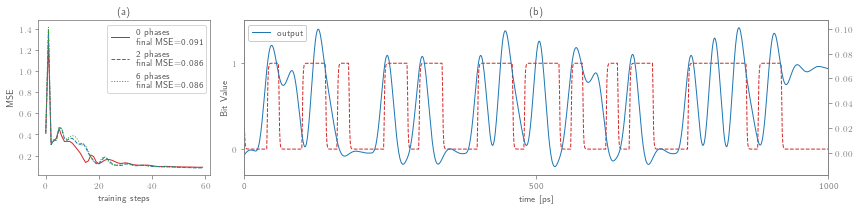

In [25]:
# test_stream = np.load('reservoir_losses/test_stream.npy')
# test_stream = np.load('reservoir_losses/test_target.npy')
# detected = np.load('reservoir_losses/detected.npy')

# Plot Output
c1 = 'C0'
c2 = 'C1'
linestyles = ['-','--','dotted','dashdot']
loss_types = ['0','2','6']
with custom_style():
    plt.figure(figsize=(12,3))
    plt.subplot(1,4,1)
    for type, ls in zip(loss_types, linestyles):
        losses = np.load('reservoir_losses/cascres%s_%s.npy'%(type, suffix))
        label = '%s phases\nfinal MSE=%.3f'%(type, losses[-1])
        plt.plot(losses, ls=ls, label=label)
    plt.title('(a)')

    plt.legend()
    plt.ylabel('MSE')
    plt.xlabel('training steps')
    #plt.savefig('../figures/reservoir_learningcurve1')
    plt.subplot2grid((1,4), (0, 1), colspan=3)
    tplot(dt, test_target, label='target', color=c1, ls='--')
    plt.ylim(-.3, 1.5)
    plt.yticks([0, 1])
    #plt.tick_params('y')#, colors=c1)
    plt.ylabel('Bit Value')#, color=c1)
    plt.xlim(100,1100)
    plt.xticks([100,600,1100],['0','500','1000'])
    plt.twinx()
    tplot(dt, detected, start=-latency*samplerate/bitrate*dt*1e12, label='output', color=c2)
    #plt.ylim(0, 0.125)
    #plt.ylabel('Ouput [mW]', color=c2)
    #plt.tick_params('y', colors=c2)
    plt.tight_layout()
    leg = plt.legend(loc='upper left', ncol=2, framealpha=1.0)
    
    #plt.legend(ncol=2)
    plt.title('(b)')
    plt.show()